In [1]:

from gurobipy import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt


In [69]:
# ---------- Data ----------

# Open the file and read the data
with open('data_large_multiTW_diff_org.txt', 'r') as f:
    data = []
    for line in f:
        # Skip empty lines
        if not line.strip():
            continue
        
        parts = line.split()
        loc_id = int(parts[0])  # Location ID
        x_coord = int(parts[1])  # X coordinate
        y_coord = int(parts[2])  # Y coordinate
        demand = int(parts[3])  # Demand
        service_time = int(parts[4])  # Service time
        num_tw = int(parts[5])  # Number of time windows
        
        # Extract time windows
        time_windows = []
        for n in range(num_tw):
            start = int(parts[6 + 2 * n])
            end = int(parts[7 + 2 * n])
            time_windows.append((start, end))
        
        # Append the parsed data as a dictionary
        data.append({
            'loc_id': loc_id,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'demand': demand,
            'service_time': service_time,
            'num_time_windows': num_tw,
            'time_windows': time_windows
        })

# Find the maximum number of time windows
max_time_windows = max(len(entry['time_windows']) for entry in data)

# Pad nodes with fewer time windows and update num_time_windows
for entry in data:
    while len(entry['time_windows']) < max_time_windows:
        entry['time_windows'].append((0, 0))

# Convert data into a structured numpy array
CVRPTW = []
for entry in data:
    node_data = [
        entry['loc_id'], entry['x_coord'], entry['y_coord'], entry['demand'], entry['service_time'], entry['num_time_windows']
    ] + entry['time_windows']

    CVRPTW.append(node_data)

CVRPTW = np.array(CVRPTW, dtype=object)

# Extract useful information
Nodes = CVRPTW[:, 0]  # nodes
n = len(Nodes)  # number of nodes
Vehicles = {0, 1, 2}

xcoord = CVRPTW[:, 1]  # x coordinates
ycoord = CVRPTW[:, 2]  # y coordinates
q = CVRPTW[:, 3]  # demand
service_duration = CVRPTW[:, 4]  # service time

# Extract time windows for each node
time_windows = CVRPTW[:, 6:]

# Define constants
Q = 200  # vehicle capacity
BIGM = 123456  # big M

# Calculate the distance matrix
distance = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            distance[i, j] = math.sqrt((xcoord[i] - xcoord[j])**2 + (ycoord[i] - ycoord[j])**2)


In [70]:
print(CVRPTW)

[[0 40 50 0 0 1 (0, 3390) (0, 0) (0, 0)]
 [1 52 75 10 90 3 (311, 471) (2487, 2772) (2123, 2278)]
 [2 45 70 30 90 3 (213, 373) (1208, 1478) (759, 975)]
 [3 62 69 10 90 2 (1167, 1327) (3033, 3338) (0, 0)]
 [4 60 66 10 90 2 (1261, 1421) (49, 233) (0, 0)]
 [5 42 65 10 90 1 (25, 185) (0, 0) (0, 0)]
 [6 16 42 20 90 3 (497, 657) (1508, 1697) (2210, 2541)]
 [7 58 70 20 90 3 (1073, 1233) (1407, 1582) (2765, 3006)]
 [8 34 60 20 90 2 (2887, 3047) (826, 1035) (0, 0)]
 [9 28 70 10 90 3 (2601, 2761) (1538, 1851) (1059, 1224)]
 [10 35 66 10 90 1 (2791, 2951) (0, 0) (0, 0)]
 [11 35 69 10 90 3 (2698, 2858) (2412, 2666) (1935, 2139)]
 [12 25 85 20 90 1 (2119, 2279) (0, 0) (0, 0)]
 [13 22 75 30 90 2 (2405, 2565) (1006, 1227) (0, 0)]
 [14 22 85 10 90 3 (2026, 2186) (3123, 3330) (2336, 2490)]
 [15 20 80 40 90 2 (2216, 2376) (978, 1282) (0, 0)]
 [16 20 85 40 90 1 (1934, 2094) (0, 0) (0, 0)]
 [17 18 75 20 90 2 (2311, 2471) (2639, 2794) (0, 0)]
 [18 15 75 20 90 2 (1742, 1902) (1003, 1212) (0, 0)]]


In [71]:

# ---------- Optimization Model ----------

# Initialize the model
m = Model("CVRPTW_MultiTW")

# Decision Variables
# x_{ijv}: Binary variable, 1 if vehicle v travels from i to j, 0 otherwise
edge = {}
for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            edge[i, j, v] = m.addVar(vtype=GRB.BINARY, lb=0, name='x_%s_%s_%s' % (i, j, v))

# service_start{ivw}: Time at which vehicle v starts service at node i at time window w
service_start = {}
for i in Nodes:
    for v in Vehicles:
            service_start[i, v] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name='t_%s_%s' % (i, v))

# z_{ivw}: Binary variable, 1 if node i is visited by vehicle v during time window w
z = {}
for i in Nodes:
    for v in Vehicles:
        for w in range(len(time_windows[int(i)])):
            z[i, v, w] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name='z_%s_%s_%s' % (i, v, w))

# if time window w is selected for node i
y = {}
for i in Nodes:
    for w in range(len(time_windows[int(i)])):
        y[i,w] = m.addVar(vtype=GRB.BINARY, lb = 0, name='y_%s_%s' % (i, w))

# if time window is not open
# wait_time = {}
# for i in Nodes:
#     for v in Vehicles:
#         wait_time[i, v] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name='wait_%s_%s' % (i, v))

m.update()


# Objective Function
obj = quicksum(distance[i,j]*edge[i,j,v] for i in Nodes for j in Nodes for v in Vehicles)
m.setObjective(obj)
m.ModelSense = GRB.MINIMIZE
m.update()

# Constraints

# each node is visited by exactly one vehicle 1
con0 = {}
for v in Vehicles:
    for i in Nodes:
        con0[i,i,v] = m.addConstr(
            edge[i,i,v] == 0, 'con0[' + str(i) + ',' + str(i) + ',' + str(v) + ']'
        )

# 
con1 = {}
for i in Nodes:
    for v in Vehicles:
        con1[i,j,v] = m.addConstr(
            quicksum(edge[i,j,v] for j in Nodes) >= quicksum(z[i, v, w] for w in range(len(time_windows[int(i)]))), 'con1[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
        )


con11 = {}
for i in Nodes:
    if i != 0:
        con11[i,v,w] = m.addConstr(
            quicksum(z[i,v,w] for v in Vehicles for w in range(len(time_windows[int(i)]))) == 1, 'con11[' + str(i) + ',' + str(v) + ',' + str(w) + ']'
        )

    
# each vehicle starts and ends at the depot
con2 = {}
con3 = {}
for v in Vehicles:
    con2[v] = m.addConstr(
        quicksum(edge[0,i,v] for i in Nodes if i != 0) <= 1, 'con2[' + str(v) + ']'
    )
    con3[v] = m.addConstr(
        quicksum(edge[i,0,v] for i in Nodes if i != 0) <= 1, 'con3[' + str(v) + ']'
    )


# Capacity constraint
con4 = {}
for v in Vehicles:
    con4[v] = m.addConstr(
        quicksum(q[i]*z[i,v,w] for i in Nodes for w in range(len(time_windows[int(i)]))) <= Q, 'con4[' + str(v) + ']'
    )


# Flow conservation excluding self-loops
con5 = {}
for i in Nodes:
    for v in Vehicles:
        con5[i, j, v] = m.addConstr(
            quicksum(edge[i, j, v] for j in Nodes) == quicksum(edge[j, i, v] for j in Nodes),
            'con5[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
        )


# time window constraints
con6 = {}
con7 = {}
con8 = {}
con9 = {}
for i in Nodes:
    for v in Vehicles:
        for w in range(len(time_windows[int(i)])):
            a_iw, b_iw = time_windows[int(i)][w]
            con6[i,v,w] = m.addConstr(
                service_start[i, v] + BIGM * (1 - y[i,w]) >= a_iw, 'con6[' + str(i) + ',' + str(v) + str(w) + ']'
                )
            con7[i,v,w] = m.addConstr(
                service_start[i, v] - BIGM * (1 - y[i,w]) <= b_iw, 'con7[' + str(i) + ',' + str(v) + str(w) +']'
                )

for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            # for w in range(len(time_windows[int(i)])):   
            if i != j and i != 0 and j != 0:
                con8[i,j,v,w] = m.addConstr(
                    service_start[j, v] >= service_start[i, v] + service_duration[int(i)] + distance[i, j] - BIGM * (1 - edge[i, j, v]), 'con8[' + str(i) + ',' + str(j) + ',' + str(v) + ',' + str(w) + ']'
                )
con12 = {}
con13 = {}

# for i in Nodes:
#     for v in Vehicles:
#         con12[i,v] = m.addConstr(
#             service_start[i,v] <= BIGM*(quicksum(edge[i,j,v] for j in Nodes)), 'con12[' + str(i) + ',' + str(v) + ']')


for i in Nodes:
    con13[i] = m.addConstr(
        quicksum(y[i,w] for w in range(len(time_windows[int(i)]))) == 1, 'con13[' + str(i) + ',' + str(w) + ']'
        )



# Waiting time
# for i in Nodes:
#     for v in Vehicles:
#         for w in range(len(time_windows[int(i)])):
#             a_iw, b_iw = time_windows[int(i)][w]
#             con9[i,v,w] = m.addConstr(service_start[i, v, w] + wait_time[i, v] <= a_iw * z[i, v, w], 'con9[' + str(i) + ',' + str(v) + ',' + str(w) + ']')

# Solve
m.update()
m.write('CVRPTW.lp')
m.Params.TimeLimit = 30600
m.optimize()

if m.status == GRB.OPTIMAL:
    print("Optimale Lösung gefunden.")
    print("Zeitfenster, in denen die Knoten besucht werden:")
    for i in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):
                if z[i, v, w].X > 0.5:  # z[i, v, w].X gibt den Wert der Variablen nach der Optimierung an
                    a_iw, b_iw = time_windows[int(i)][w]
                    print(f"Node {i} wird von Fahrzeug {v} im Zeitfenster ({a_iw}, {b_iw}) besucht.")
else:
    print("Keine optimale Lösung verfügbar.")

if m.status == GRB.OPTIMAL:
    print("Optimale Lösung gefunden.")
    print("Service-Startzeiten:")
    for i in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):
                if z[i, v, w].X > 0.5:  # Prüft, ob das Fahrzeug i im Zeitfenster w besucht
                    start_time = service_start[i, v].X
                    print(f"Fahrzeug {v} startet den Service bei Node {i} im Zeitfenster {w} um Zeit {start_time:.2f}.")
else:
    print("Keine optimale Lösung verfügbar.")

#Debugging
if m.status == GRB.INFEASIBLE:
    m.computeIIS() 

    for c in m.getConstrs():
        if c.IISConstr: 
            print('Unzulässige Constraint:', c.constrName)

    for v in m.getVars():
        if v.IISLB > 0 or v.IISUB > 0:
            print('Problem bei der Variable:', v.varName)


Set parameter TimeLimit to value 30600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1477 rows, 1368 columns and 7290 nonzeros
Model fingerprint: 0xa4925ef8
Variable types: 228 continuous, 1140 integer (1140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 374 rows and 230 columns
Presolve time: 0.09s
Presolved: 1103 rows, 1138 columns, 6862 nonzeros
Variable types: 108 continuous, 1030 integer (1030 binary)

Root relaxation: objective 1.353717e+02, 202 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

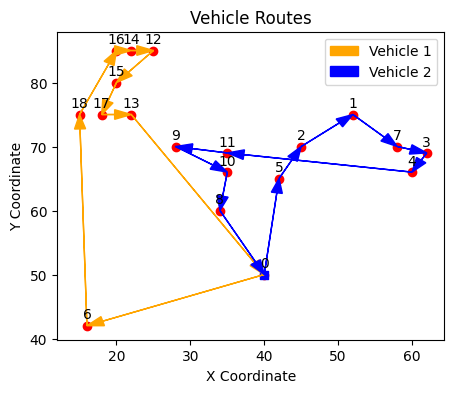

In [72]:
# Extract the routes from the solution
routes = {v: [] for v in Vehicles}
if m.status == GRB.OPTIMAL:
    for v in Vehicles:
        for i in Nodes:
            for j in Nodes:
                if edge[i, j, v].X > 0.5:
                    routes[v].append((i, j))

    # Plot the routes
    plt.figure(figsize=(5, 4))
    plt.scatter(xcoord, ycoord, c='red')
    plt.scatter(xcoord[0], ycoord[0], c='blue', marker='s')  # depot

    for i, (x, y) in enumerate(zip(xcoord, ycoord)):
        plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    colors = ['green', 'orange', 'blue']  # Define colors for each vehicle
    for v in Vehicles:
        for (i, j) in routes[v]:
            plt.arrow(xcoord[i], ycoord[i], xcoord[j] - xcoord[i], ycoord[j] - ycoord[i], 
                      color=colors[v], head_width=1.5, length_includes_head=True, label=f'Vehicle {v}' if i == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.legend()
    plt.show()
else:
    print("No optimal solution found.")


In [73]:
# Create a dataframe to store the results for all vehicles
df_all = pd.DataFrame(columns=['Vehicle', 'Node', 'Service Start', 'Load'])

for v in Vehicles:
    print(f"Vehicle {v} service times and loads:")
    sorted_routes = sorted(routes[v], key=lambda x: service_start[x[0], v].X)
    load = 0
    for (i, j) in sorted_routes:
        load += q[i] * sum(z[i, v, w].X for w in range(len(time_windows[int(i)])))
        print(f"  Node {i}: Service start at {service_start[i, v].X:.2f}, Load: {load}")
        new_row = pd.DataFrame({'Vehicle': [v], 'Node': [i], 'Service Start': [service_start[i, v].X], 'Load': [load]})
        if not new_row.isna().all(axis=None):
            df_all = pd.concat([df_all, new_row], ignore_index=True)

    print("\n")

df_all
# show the total distance traveled by all vehicles
total_distance = 0
for v in Vehicles:
    for (i, j) in routes[v]:
        total_distance += distance[i, j]
print(f"Total distance traveled by all vehicles: {total_distance:.2f}")

Vehicle 0 service times and loads:


Vehicle 1 service times and loads:
  Node 0: Service start at 0.00, Load: 0.0
  Node 6: Service start at 1508.00, Load: 20.0
  Node 18: Service start at 1742.00, Load: 40.0
  Node 16: Service start at 1934.00, Load: 80.0
  Node 14: Service start at 2026.00, Load: 90.0
  Node 12: Service start at 2278.54, Load: 110.0
  Node 15: Service start at 2375.61, Load: 150.0
  Node 17: Service start at 2471.00, Load: 170.0
  Node 13: Service start at 2565.00, Load: 200.0


Vehicle 2 service times and loads:
  Node 0: Service start at 0.00, Load: 0.0
  Node 5: Service start at 0.00, Load: 10.0
  Node 2: Service start at 213.00, Load: 40.0
  Node 1: Service start at 471.00, Load: 50.0
  Node 7: Service start at 1073.00, Load: 70.0
  Node 3: Service start at 1167.12, Load: 80.0
  Node 4: Service start at 1421.00, Load: 90.0
  Node 11: Service start at 2412.00, Load: 100.0
  Node 9: Service start at 2601.00, Load: 110.0
  Node 10: Service start at 2950.92, Load: 1

C:\Users\kai-s\AppData\Local\Temp\ipykernel_23212\1257807096.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, new_row], ignore_index=True)
